# *West Coast Hackathon Demo*

## June 20, 2018

*Adarsh Pyarelal*

This notebook shows an example of a CAG that is semi-automatically assembled from reading evidence, dressed with probability distributions and turned into a dynamical Bayesian network, and parameterized with data from three sources: FAO, WDI, and models (DSSAT and CYCLES).

First, the preliminaries:

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from delphi.core import *
from future.utils import lfilter
import pandas as pd
import networkx as nx
from IPython.display import Image
import datetime
from tqdm import trange
import seaborn as sns

Specify the data directory that contains the JSON-LD files output from Eidos from reading the 52 documents provided by MITRE.

In [2]:
json_ld_files_dir = '../data/52_docs_jsonlds/*.jsonld'

Construct INDRA statements out of the JSON-LD data:

In [3]:
statements = list(get_indra_statements_from_directory(json_ld_files_dir))

100%|██████████| 52/52 [00:04<00:00, 11.64it/s]


This results in 2505 statements.

In [4]:
len(statements)

2505

Specify relevant concepts that you are interested in:

In [5]:
relevant_concepts=['conflict', 'food_security', 'precipitation']

Get the statements that satisfy the following criteria:

- The statement contains at least one of the relevant concepts above.
- both the subject and object of the statement are grounded to the UN ontology with a score > 0.7.
- both the subject and object have attached polarities (increase/decrease).

In [6]:
def isGoodStatement(s):
    return (is_well_grounded(s) 
            and isSimulable(s)
            and contains_relevant_concept(s, relevant_concepts))

good_statements = lfilter(isGoodStatement, statements)

This results in 23 statements:

In [7]:
len(good_statements)

23

Create a table with the statement information, manually check whether they make sense.
(Human in the loop!)

In [8]:
pd.options.display.max_colwidth=1000
pd.options.display.width=1000
columns = [ 'subj_text', 'canonical name (subj)', 'un (subj)', 'obj_text',
            'canonical name (obj)', 'un (obj)', 'sentence', ]

df = pd.DataFrame([(x[1].subj.db_refs['TEXT'].replace('\n',' '),
                    x[1].subj,
                    (x[1].subj.db_refs['UN'][0][0].split('/')[-1],
                     f"{top_grounding_score(x[1].subj):.2f}"),
                    x[1].obj.db_refs['TEXT'].replace('\n',' '),
                    x[1].obj,
                    (x[1].obj.db_refs['UN'][0][0].split('/')[-1],
                     f"{top_grounding_score(x[1].obj):.2f}"),
                    x[1].evidence[0].text.replace('\n',' ')
                ) for x in list(enumerate(good_statements))
        ], columns=columns)
df

,subj_text,canonical name (subj),un (subj),obj_text,canonical name (obj),un (obj),sentence
0,conflict,conflict,"(conflict, 0.80)",crop production,crop production,"(crop_technology, 0.71)","conflict into the most productive state of the country, which also led to a sharp decrease in cultivated area and crop production"
1,conflict,conflict,"(conflict, 0.80)",humanitarian assistance,assistance,"(intervention, 0.84)",conflict further disrupts livelihoods and limits humanitarian assistance
2,summer rainfall,rainfall,"(precipitation, 0.88)",Rainfall,Rainfall,"(precipitation, 0.88)","Rainfall has Declined by 20 Percent Between the mid-1970s and late 2000s, summer rainfall"
3,additional November rains,rain,"(precipitation, 0.82)",water conditions,water,"(irrigation, 0.74)","additional November rains modestly improving crop, pasture and water conditions"
4,rains,rain,"(precipitation, 0.82)",food insecurity,food insecurity,"(food_insecurity, 0.77)",food insecurity is driven by consecutive poor rains
5,conflict,conflict,"(conflict, 0.80)",people’s food insecurity,people food insecurity,"(food_insecurity, 0.71)",conflict also increases people’s food insecurity
6,precipitation,precipitation,"(precipitation, 0.86)",snow accumulation,snow accumulation,"(precipitation, 0.76)",precipitation leading to below-average snow accumulation
7,rains in the two countries,rain,"(precipitation, 0.82)",water availability,water,"(irrigation, 0.74)",rains in the two countries will limit pasture regeneration and water availability
8,fighting,fighting,"(conflict, 0.74)",levels of acute malnutrition across South Sudan,malnutrition,"(food_insecurity, 0.81)","fighting, displacement and poor access to services, disease outbreaks, extremely poor diet (in terms of both quality and quantity), low coverage of sanitation facilities and poor hygiene practices are the key drivers of the high levels of acute malnutrition across South Sudan"
9,rains,rain,"(precipitation, 0.82)",already under-developed roads,road,"(road, 0.89)",already under-developed roads and airstrips deteriorate every year with cumulative effects of heavy rains


Select statements that make sense.

In [9]:
good_statement_indices=[0, 2, 3, 4, 5, 6, 8, 10, 11, 14, 15, 16, 17, 18, 19, 
                       20, 21, 22,]

manually_selected_statements = [good_statements[i] for i in good_statement_indices]

This whittles the number of statements down to 18. 

In [10]:
len(manually_selected_statements)

18

Dress the CAG - that is, attach probability distributions based on gradable adjectives to the edges of the CAG.

In [11]:
CAG = create_dressed_CAG(manually_selected_statements,
                         '../data/adjectiveData.tsv')

Visualize the CAG!

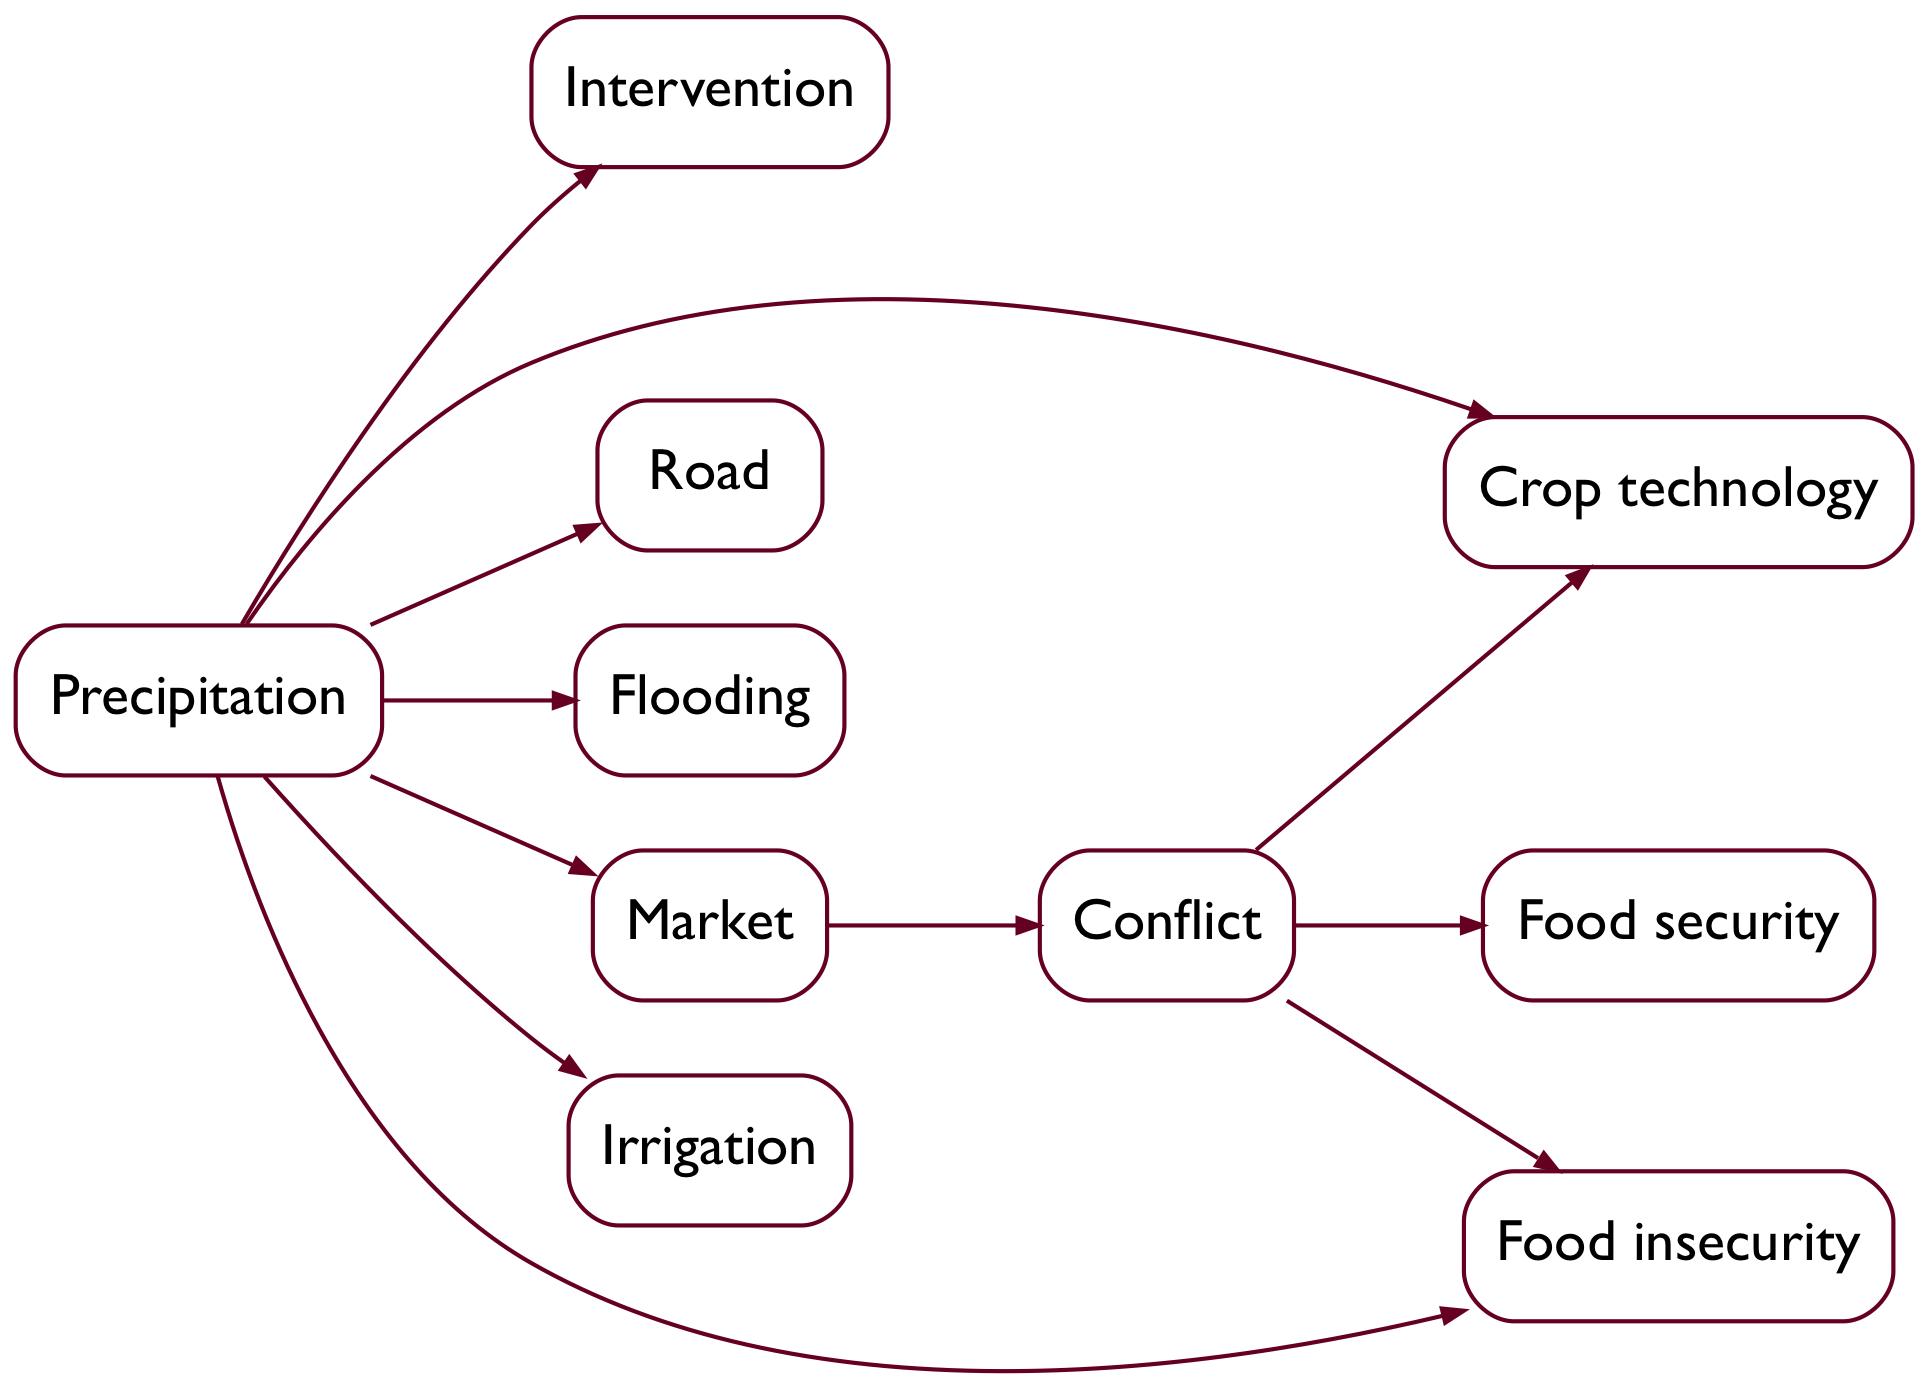

In [12]:
def create_pygraphviz_CAG(CAG):
    A = nx.nx_agraph.to_agraph(nx.DiGraph([(e[0].capitalize(), e[1].capitalize())
                                            for e in CAG.edges()]))

    A.graph_attr['dpi']=300
    A.graph_attr['fontsize']=5
    A.graph_attr['overlap']='scale'
    A.graph_attr['rankdir'] = 'LR'
    A.edge_attr.update({'arrowsize': 0.5, 'color': '#650021'})
    A.node_attr.update({'shape': 'rectangle', 'color': '#650021',
                        'style':'rounded', 'fontname':'Gill Sans'})
    return A
A = create_pygraphviz_CAG(CAG)
Image(A.draw(format='png', prog='dot'))

Associate indicators with the abstract concepts, where available:

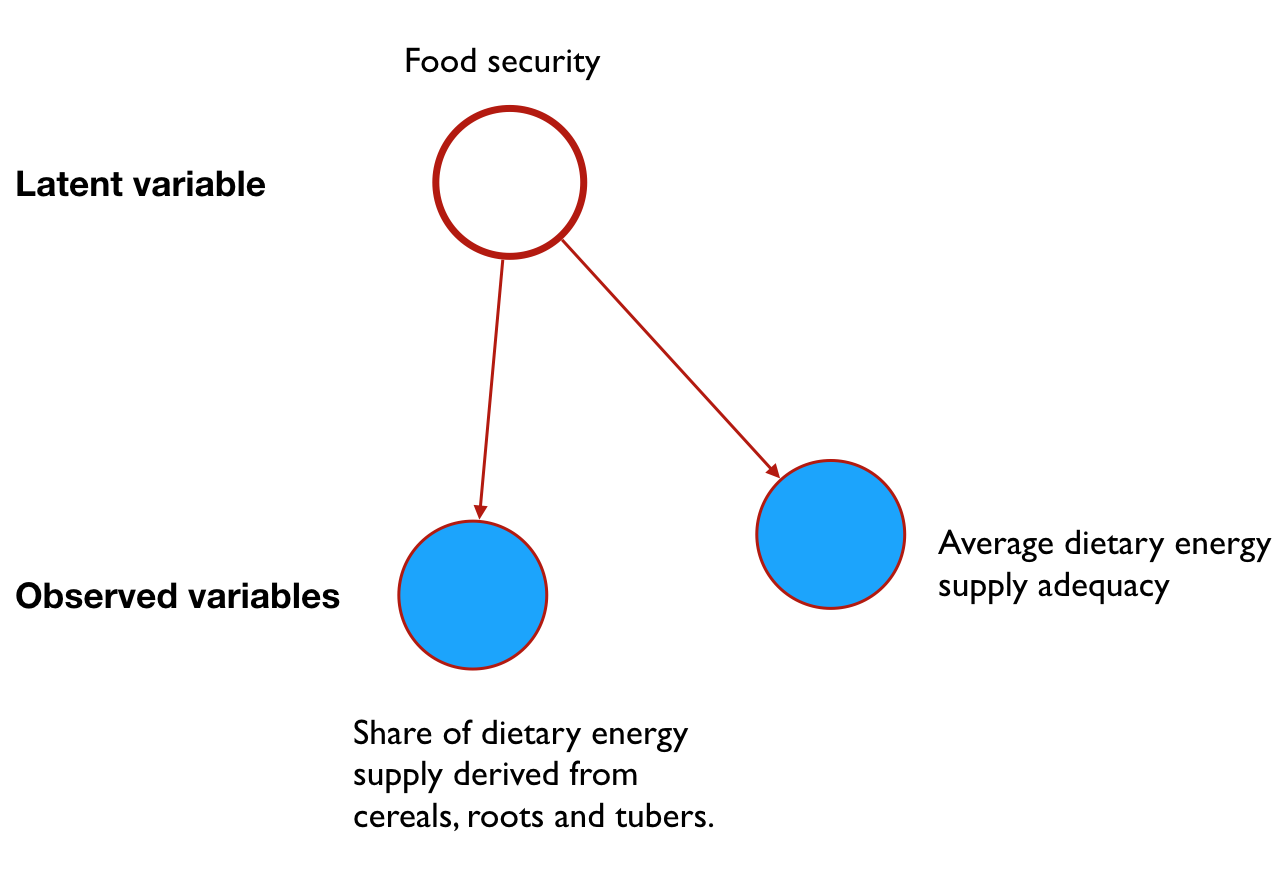

In [13]:
Image('latent_vs_observed.png')

Let $n_{ij}$ be value of the $j^{th}$ indicator for the $i^{th}$ component of a latent state vector $\mathbf{s}$. Define the probability distribution for sampling the value of the indicator:

$$n_{ij}\sim \mathcal{N}(s_i\mu_{ij}, \sigma_{ij})$$
where $\mu_{ij}, \sigma_{ij}$ are the mean and standard deviation of the indicator $n_{ij}$.

Below we add the indicators to the CAG visualization (blue nodes).

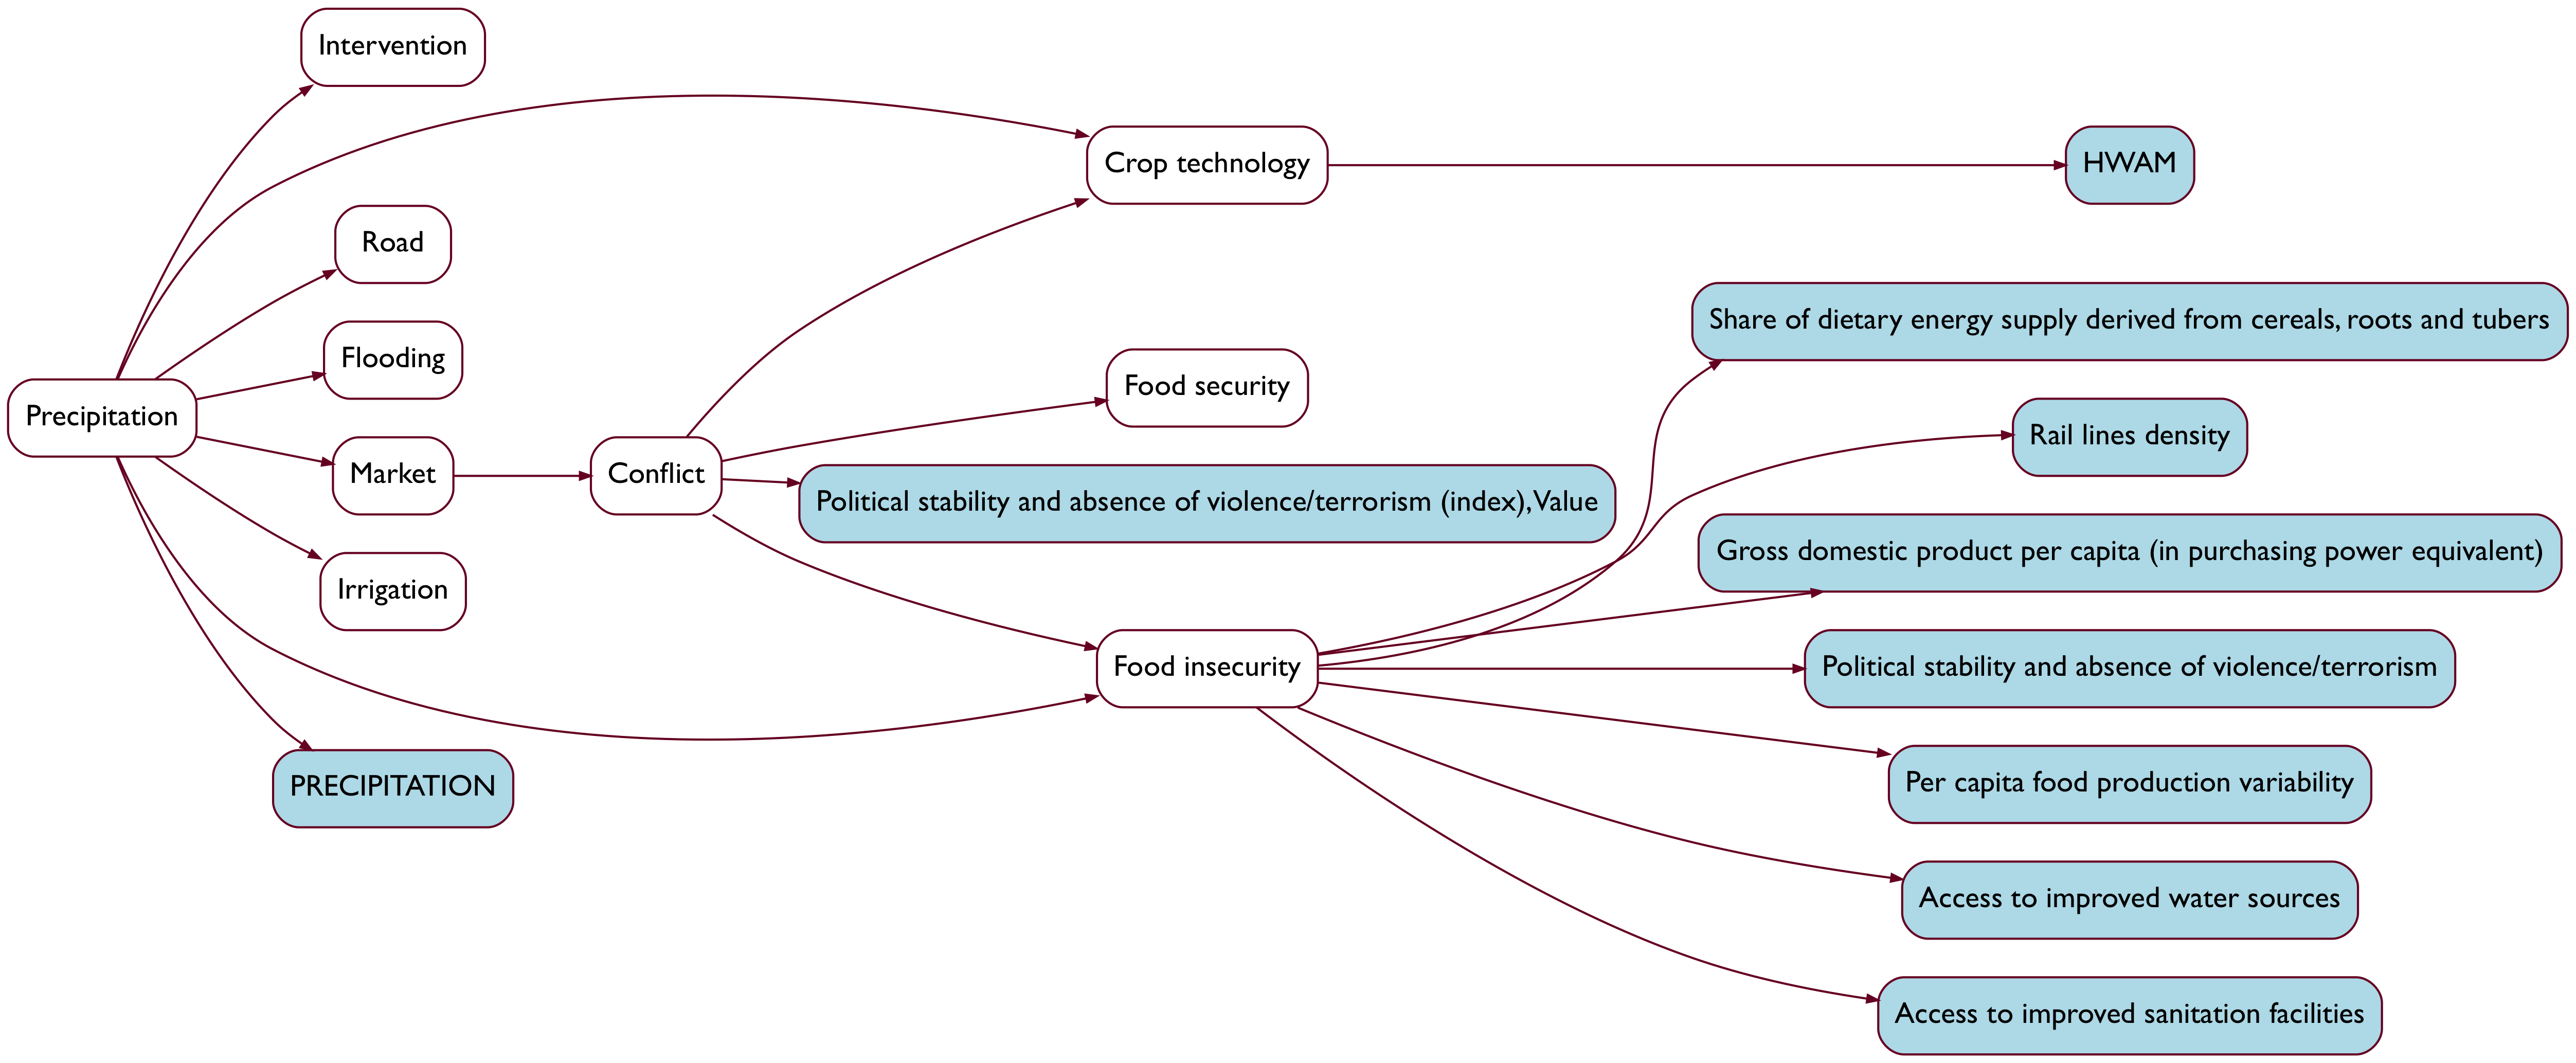

In [30]:
def add_indicators_to_CAG_viz(A, CAG):
    for n in CAG.nodes(data = True):
        if n[1].get('indicators') is not None:
            for ind in n[1]['indicators']:
                node_label = ind.name
                A.add_node(node_label, style='rounded, filled', fillcolor = 'lightblue')
                A.add_edge(n[0].capitalize(), node_label)
    A.graph_attr['rankdir']='LR'
    A.graph_attr['overlap']='scale'
    return A
                
A = add_indicators_to_CAG_viz(A, CAG)               
Image(A.draw(format='png', prog='dot'))

In [15]:
CAG = set_indicators(CAG)
def print_indicators():
    for n in CAG.nodes(data = True):
        print(n[0])
        if n[1]['indicators'] is not None:
            for ind in n[1]['indicators']:
                print('\t', ind.name, ind.value)
print_indicators()

precipitation
intervention
crop technology
road
flooding
market
irrigation
food insecurity
	 average dietary energy supply adequacy None
	 average value of food production None
	 Share of dietary energy supply derived from cereals, roots and tubers None
	 Rail lines density None
	 Gross domestic product per capita (in purchasing power equivalent) None
	 Prevalence of undernourishment None
	 Prevalence of severe food insecurity in the total population None
	 Depth of the food deficit None
	 Cereal import dependency ratio None
	 Percentage of arable land equipped for irrigation None
	 Value of food imports over total merchandise exports None
	 Political stability and absence of violence/terrorism None
	 Per capita food production variability None
	 Per capita food supply variability None
	 Access to improved water sources None
	 Access to improved sanitation facilities None
	 Percentage of children under 5 years of age affected by wasting None
	 Percentage of children under 5 years of ag

Get indicator values from FAO and WDI data, where available:

In [16]:
faostat_wdi_df = get_faostat_wdi_data('../data/south_sudan_data.csv')
CAG = set_indicator_values(CAG, datetime.datetime(2012, 1,1), faostat_wdi_df)
print_indicators()

precipitation
intervention
crop technology
road
flooding
market
irrigation
food insecurity
	 Share of dietary energy supply derived from cereals, roots and tubers 9870.4028
	 Rail lines density 0.0
	 Gross domestic product per capita (in purchasing power equivalent) 6548100.0
	 Political stability and absence of violence/terrorism -1.2
	 Per capita food production variability 1760178.9640400002
	 Access to improved water sources 58.7
	 Access to improved sanitation facilities 6.6
conflict
	 Political stability and absence of violence/terrorism (index), Value -1.2
food security


Get indicators values from DSSAT:

In [17]:
dssat_output_df = pd.read_csv('Summary.OUT',skiprows=3,delim_whitespace=True)

Create mapping between the node *crop technology* (probably a better name should be crop yield) and the indicator variable `HWAM`: Yield at harvest maturity (kg [dm]/ha)

In [18]:
dssat_mapping = { 'crop technology': 'HWAM' }
for n in CAG.nodes():
    if n in dssat_mapping:
        indicator_name = dssat_mapping[n]
        value = dssat_output_df[indicator_name][0]
        CAG.nodes[n]['indicators'] = [Indicator(indicator_name, 'DSSAT',
                                                value, 0.001*value)]
print_indicators()

precipitation
intervention
crop technology
	 HWAM 1215
road
flooding
market
irrigation
food insecurity
	 Share of dietary energy supply derived from cereals, roots and tubers 9870.4028
	 Rail lines density 0.0
	 Gross domestic product per capita (in purchasing power equivalent) 6548100.0
	 Political stability and absence of violence/terrorism -1.2
	 Per capita food production variability 1760178.9640400002
	 Access to improved water sources 58.7
	 Access to improved sanitation facilities 6.6
conflict
	 Political stability and absence of violence/terrorism (index), Value -1.2
food security


Get data and indicators from CYCLES:

In [19]:
def create_cycles_output_df():
    df = pd.read_table('weather.dat')
    df.columns = [col.strip() for col in df.columns]
    return df

cycles_output_df = create_cycles_output_df()

In [20]:
cycles_mapping = {'precipitation': 'PRECIPITATION'}
for n in CAG.nodes():
    if n in cycles_mapping:
        indicator_name = cycles_mapping[n]
        value = cycles_output_df.loc[4020:4385][indicator_name].values\
                                                               .astype(float)\
                                                               .mean()
        CAG.nodes[n]['indicators'] = [Indicator(indicator_name, 'CYCLES',
                                                value, 0.01*value)]
        
print_indicators()

precipitation
	 PRECIPITATION 2.8709016393442623
intervention
crop technology
	 HWAM 1215
road
flooding
market
irrigation
food insecurity
	 Share of dietary energy supply derived from cereals, roots and tubers 9870.4028
	 Rail lines density 0.0
	 Gross domestic product per capita (in purchasing power equivalent) 6548100.0
	 Political stability and absence of violence/terrorism -1.2
	 Per capita food production variability 1760178.9640400002
	 Access to improved water sources 58.7
	 Access to improved sanitation facilities 6.6
conflict
	 Political stability and absence of violence/terrorism (index), Value -1.2
food security


Construct a default latent state vector $\mathbf{s}$:

In [21]:
s0 = construct_default_initial_state(get_latent_state_components(CAG)) 
s0

precipitation            1.0
∂(precipitation)/∂t      0.0
intervention             1.0
∂(intervention)/∂t       0.0
crop technology          1.0
∂(crop technology)/∂t    0.0
road                     1.0
∂(road)/∂t               0.0
flooding                 1.0
∂(flooding)/∂t           0.0
market                   1.0
∂(market)/∂t             0.0
irrigation               1.0
∂(irrigation)/∂t         0.0
food insecurity          1.0
∂(food insecurity)/∂t    0.0
conflict                 1.0
∂(conflict)/∂t           0.0
food security            1.0
∂(food security)/∂t      0.0
dtype: float64

What is the impact of increasing rainfall on crop production?

$\frac{\partial{(precipitation)}}{\partial{t}} = 0.01$

In [22]:
s0['∂(precipitation)/∂t'] = 0.01

Sample a set of latent state sequences and a set of observed state sequences.

In [23]:
latent_states = [sample_sequence_of_latent_states(CAG, s0.values, 5) 
                 for i in trange(1000)]
observed_states = [pd.concat(sample_sequence_of_observed_states(CAG, s),
                             axis=1) for s in latent_states]

100%|██████████| 1000/1000 [00:05<00:00, 184.63it/s]


Select two indicators that you are interested in:

In [24]:
values = {k:[df.loc[k] for df in observed_states] 
          for k in ['PRECIPITATION', 'HWAM']}

Plot the distributions of the indicators for four time steps:

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


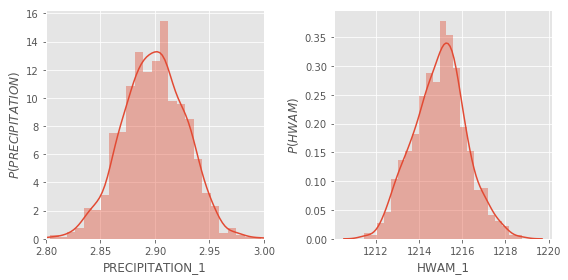

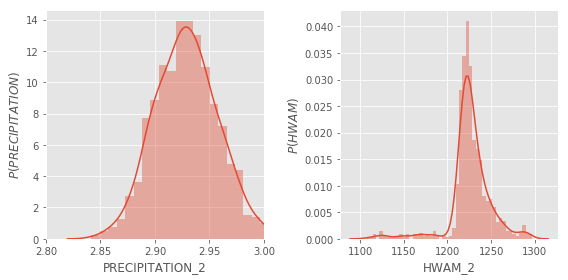

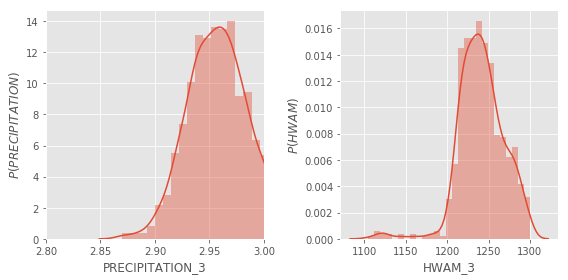

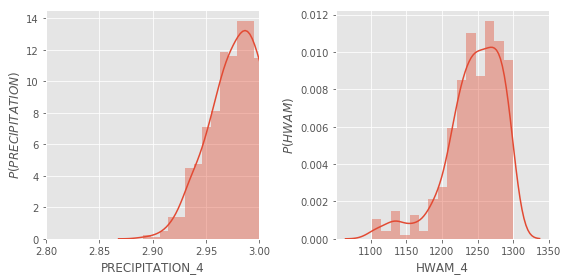

In [29]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')
def plot_hist(v1, v2, time_step):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    sns.distplot([v.loc[time_step] for v in values[v1]], ax=ax[0])
    sns.distplot([v.loc[time_step] for v in values[v2] 
                  if 1100 < v.loc[time_step]< 1300], ax=ax[1])
    ax[0].set_xlabel(v1+'_'+str(time_step))
    ax[1].set_xlabel(v2+'_'+str(time_step))
    ax[0].set_xlim(2.8,3.0)
    ax[0].set_ylabel(f'$P({v1})$')
    ax[1].set_ylabel(f'$P({v2})$')
    plt.tight_layout()

for t in range(1,5):
    plot_hist('PRECIPITATION', 'HWAM', t)

Do the distributions make sense?
Drill down!!

The next command gets the influence statements that have precipitation as the subject and crop technology as the object.

In [26]:
for i, s in enumerate(CAG.edges['precipitation',
                                'crop technology']['InfluenceStatements']):
    print('Statement ',i)
    print('\t subj:', s.subj)
    print('\t obj:', s.obj)
    print('\t subj_delta:', s.subj_delta)
    print('\t obj_delta:', s.obj_delta)
    print('\t obj_delta:', s.evidence)

Statement  0
	 subj: rainfall
	 obj: farming
	 subj_delta: {'adjectives': [], 'polarity': -1}
	 obj_delta: {'adjectives': [], 'polarity': -1}
	 obj_delta: [Evidence(eidos, None, {'found_by': 'ported_syntax_1_verb-Causal', 'provenance': [{'@type': 'Provenance', 'document': {'@id': '_:Document_1'}, 'documentCharInterval': [{'@type': 'Interval', 'start': 2471, 'end': 2547}], 'sentence': {'@id': '_:Sentence_19'}, 'positions': [{'@type': 'Interval', 'start': 21, 'end': 32}]}]}, levels of rainfall have badly disrupted this year’s
normal farming activities)]


We can see that rainfall (grounded to precipitation) and farming (grounded to crop technology) have identical polarities. In our model, this results in a positive correlation - i.e. the statement says 'a decrease in precipitation (rainfall) leads to a decrease in crop technology (farming)'.

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


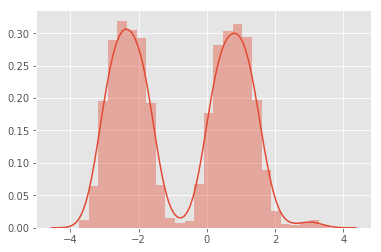

In [27]:
sns.distplot(CAG.edges['precipitation', 'crop technology']\
             .get('ConditionalProbability').resample(10000))

Right now, we are going from latent variables to observed variables. *However*, we also get the reverse for free - given observations generated by predictions from expert models (TOPOFLOW, DSSAT, etc.), we can infer the posterior probability of latent state variables like food security (right now modeled as a continuous variable, but can also be discrete).